In [1]:
%matplotlib inline
import numpy 
import pandas
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

from retina_best import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../data/hits.csv', index_col=0)

# Track finding

In [4]:
from combination import Combinator
from metrics import TracksReconstractionMetrics, CombinatorQuality

In [5]:
%%time
event_ids = numpy.unique(data.EventID.values)

tracks12 = {}
tracks34 = {}
tracks_comb = {}

tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

for event_id in event_ids:
    try:
        # Get an event
        event = data[data.EventID == event_id]
        event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
        event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]

        # Tracks reconstruction before the magnet
        tr2d = RetinaTrackReconstruction(pre_sigma=0.8, inlier_treshold=0.7, x_resolution=1, y_resolution=1,\
                                         de_popsize=20, adjusting=True, seed=42)
        tr2d.fit(event)

        labels12 = tr2d.labels_[0]
        tracks_params12 = tr2d.tracks_params_[0]

        # Quality metrics of the reconstruction
        trm12 = TracksReconstractionMetrics(0.2)
        trm12.fit(labels12, event12)

        tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                     trm12.avg_efficiency_, 
                                                                     trm12.recognition_efficiency_, 
                                                                     trm12.ghost_rate_, 
                                                                     trm12.clone_rate_]

        labels34 = tr2d.labels_[1]
        tracks_params34 = tr2d.tracks_params_[1]

        # Quality metrics of the reconstruction
        trm34 = TracksReconstractionMetrics(0.2)
        trm34.fit(labels34, event34)

        tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                     trm34.avg_efficiency_, 
                                                                     trm34.recognition_efficiency_, 
                                                                     trm34.ghost_rate_, 
                                                                     trm34.clone_rate_]


        # Save the reconstructed tracks
        tracks12[event_id] = {'labels':labels12, 'params':tracks_params12}
        tracks34[event_id] = {'labels':labels34, 'params':tracks_params34}


        # Combination of the tracks before and after the magnet
        comb = Combinator()
        comb.combine(tracks_params12, tracks_params34)

        for num in range(len(comb.tracks_combinations_)):

            combinations.loc[len(combinations)] = [event_id, 
                                                   comb.tracks_combinations_[num][0], 
                                                   comb.tracks_combinations_[num][1], 
                                                   comb.charges_[num], 
                                                   comb.inv_momentums_[num]]

        # Quality of the combination

        cq = CombinatorQuality()
        cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

        combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                               cq.reco_eff_, 
                                                               cq.ghost_rate_, 
                                                               cq.clone_rate_, 
                                                               cq.n_combined_]

        for num in range(len(cq.check_tracks_combinations_)):

            combinations_true.loc[len(combinations_quality)] = [event_id, 
                                                                   cq.check_tracks_combinations_[num], 
                                                                   cq.true_pdg_codes_[num], 
                                                                   cq.true_charges_[num],
                                                                   cq.check_charges_[num], 
                                                                   cq.true_inv_momentums_[num], 
                                                                   cq.momentums_err_[num],
                                                                   cq.labels_[num]]



        # Overall quality
        pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                         (trm12.recognition_efficiency_ == 1)*1,
                                                         (trm34.recognition_efficiency_ == 1)*1, 
                                                         (cq.n_combined_ >= 2)*1,
                                                         (cq.reco_eff_ == 1)*1]).cumprod()

        if not (trm12.recognition_efficiency_ == 1):
            print 1, event_id
        elif not (trm34.recognition_efficiency_ == 1):
            print 2, event_id
        elif not (cq.n_combined_ >= 2):
            print 3, event_id



        # Save the tracks combination
        tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                                 'charges':comb.charges_,
                                 'inv_momentums':comb.inv_momentums_}
    except:
        print 'crashed at' + str(event_id)

3 381
crashed at1528
crashed at2040
3 3085
1 3165
2 3670
1 4334
CPU times: user 16min 9s, sys: 2.26 s, total: 16min 11s
Wall time: 16min 10s


# Deviation in stereo

In [6]:
event_ids = np.unique(data.EventID.values)

ks_before = []
ks_after = []

for event_id in event_ids:
    
    event = data[data.EventID == event_id]
    
    track1 = event[event.TrackID == 2]
    
    Xs_before = track1[track1.StatNb<3].X.values
    Zs_before = track1[track1.StatNb<3].Z.values
    
    Xs_after = track1[track1.StatNb>2].X.values
    Zs_after = track1[track1.StatNb>2].Z.values
    
    k_before, b_before = np.polyfit(Zs_before, Xs_before, 1)
    ks_before.append(k_before)
    
    k_after, b_after = np.polyfit(Zs_after, Xs_after, 1)
    ks_after.append(k_after)
    
    track1 = event[event.TrackID == 3]
    
    Xs_before = track1[track1.StatNb<3].X.values
    Zs_before = track1[track1.StatNb<3].Z.values
    
    Xs_after = track1[track1.StatNb>2].X.values
    Zs_after = track1[track1.StatNb>2].Z.values
    
    k_before, b_before = np.polyfit(Zs_before, Xs_before, 1)
    ks_before.append(k_before)
    
    k_after, b_after = np.polyfit(Zs_after, Xs_after, 1)
    ks_after.append(k_after)
    
ks_before = np.array(ks_before)
ks_after = np.array(ks_after)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.10000000e+01,   1.26400000e+03,   1.50000000e+01,
          8.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

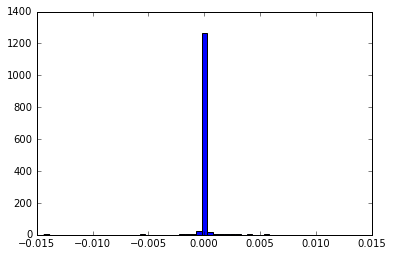

In [7]:
plt.hist(ks_before - ks_after, bins=50)

# Track eff vs Reco eff

In [40]:
%%time

event_ids = list(event_ids)
event_ids.remove(1528)
event_ids.remove(2040)

tresholds = np.linspace(0.2, 1, 15)
effs = []

for treshold in tresholds:
    
    ps = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

    for event_id in event_ids:

        event = data[data.EventID == event_id]
        event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
        event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]

        labels12 = tracks12[event_id]['labels']
        tracks_params12 = tracks12[event_id]['params']

        # Quality metrics of the reconstruction
        trm12 = TracksReconstractionMetrics(treshold)
        trm12.fit(labels12, event12)

        labels34 = tracks34[event_id]['labels']
        tracks_params34 = tracks34[event_id]['params']

        # Quality metrics of the reconstruction
        trm34 = TracksReconstractionMetrics(treshold)
        trm34.fit(labels34, event34)

        # Combination of the tracks before and after the magnet
        comb = Combinator()
        comb.combine(tracks_params12, tracks_params34)

        # Quality of the combination
        cq = CombinatorQuality()
        cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

        # Overall quality
        ps.loc[len(ps)] = numpy.array([1, 
                                       (trm12.recognition_efficiency_ == 1)*1,
                                       (trm34.recognition_efficiency_ == 1)*1, 
                                       (cq.n_combined_ >= 2)*1,
                                       (cq.reco_eff_ == 1)*1]).cumprod()

    bar_values = ps.sum(axis=0).values
    bar_values = bar_values / bar_values[0] * 100

    effs.append(bar_values[-1])
    
effs = np.array(effs)

CPU times: user 51.4 s, sys: 0 ns, total: 51.4 s
Wall time: 51.4 s


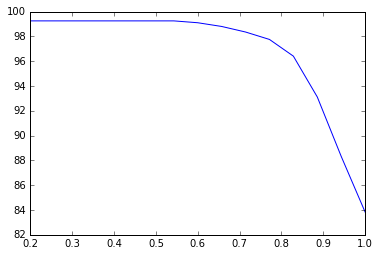

In [41]:
plt.plot(tresholds, effs)

# Efficiency per track

In [25]:
tracks = {}
for key in tracks12.keys():
    tracks[key] = {'labels12':tracks12[key]['labels'], 'params12':tracks12[key]['params'],\
                   'labels34':tracks34[key]['labels'], 'params34':tracks34[key]['params']}

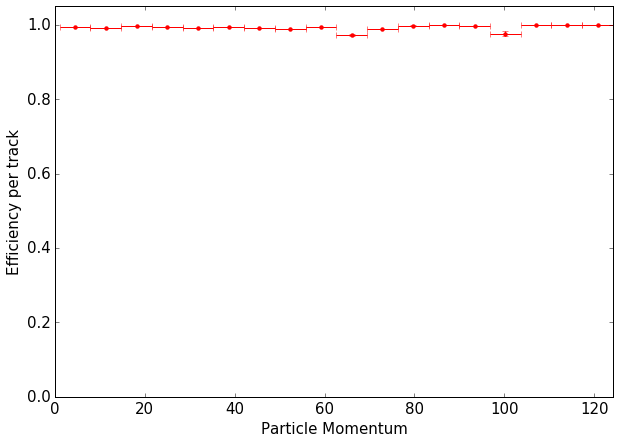

In [26]:
from utils import *

tracks_eff = get_effs_per_track_and_p(tracks, data, event_ids)

x_means, y_means, x_err, y_err = get_bins(tracks_eff.Momentum.values,
                                          tracks_eff.Eff.values,
                                          20,
                                          tracks_eff.Momentum.values.min(),
                                          tracks_eff.Momentum.values.max())

plt.figure(figsize=(10, 7))
plt.scatter(x_means, y_means, linewidth=0, color='r')
plt.errorbar(x_means, y_means, xerr=x_err, yerr=y_err, fmt='none', ecolor='r')
plt.ylim(0.0, 1.05)
plt.xlim(0, x_means[-3]+x_err[-3])
plt.xlabel('Particle Momentum', size=15)
plt.ylabel('Efficiency per track', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()